In [1]:
# need to check bias term
# need to check regularization term
# recurrent connection is all zero 


import sys
sys.path.append('../')

from low_rank_rnns.modules_connectivity_fullRank import *
from low_rank_rnns import TF, stats, plotting as plot, helpers, rankone, ranktwo, clustering

from matplotlib import pyplot as plt
# %matplotlib notebook
import random
import numpy as np

import torch

In [2]:
size = 300
noise_std = 1e-2
alpha = .1
lr = 1e-3

input_size = 3
output_size = 1


In [3]:
x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(10000)


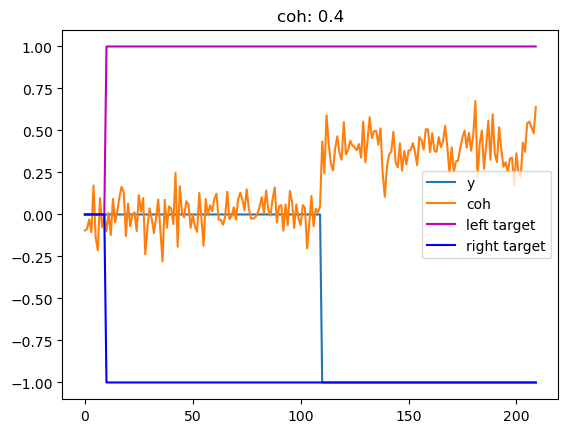

In [4]:
n = 8

plt.plot(y_val[n,:,:], label = 'y')
plt.plot(x_val[n,:,0], label = 'coh')
plt.plot(x_val[n,:,1], 'm', label = 'left target')
plt.plot(x_val[n,:,2], 'b', label = 'right target')
plt.title('coh: ' + str(cohAll_val[n]))
plt.legend()




In [5]:
# wrec_mask = torch.zeros(size, size)
# wi_mask = torch.ones(input_size, size)
# wo_mask = torch.ones(size, output_size)


# wrec_mask[80:,:] = -1
# wrec_mask[:80,:] = 0.2

# plt.imshow(wrec_mask)
# plt.colorbar()


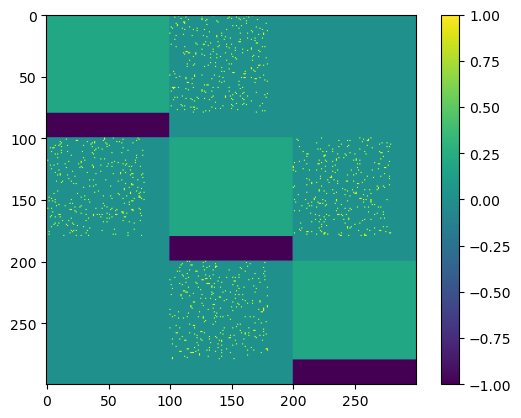

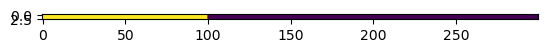

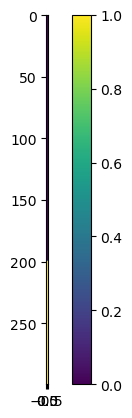

In [5]:
# local connections are sparce
# def create_local_conn(Inum, ratio, n_neurons):

#     mask_rec = torch.zeros(n_neurons, n_neurons)
    
#     mask_rec[:,n_neurons-Inum:] = -1
    
#     # Define the size of the matrix
#     rows, cols = n_neurons, n_neurons-Inum
    
#     # Create a zero matrix
#     matrix = torch.zeros(rows, cols)
    
#     # Calculate the number of entries to set to 1
#     num_entries = int(ratio * rows * cols)
    
#     # Randomly select indices
#     indices = torch.randperm(rows * cols)[:num_entries]
    
#     # Set the selected entries to 1
#     matrix.view(-1)[indices] = 1
    
#     mask_rec[:,:n_neurons-Inum] = matrix    

#     return mask_rec

# local connections are continuous 
def create_local_conn(Inum, ratio, n_neurons):

    mask_rec = torch.zeros(n_neurons, n_neurons)
    
    mask_rec[:,n_neurons-Inum:] = -1
    
    mask_rec[:,:n_neurons-Inum] = ratio    

    return mask_rec



def create_area_conn(Inum, ratio, n_neurons): 
    mask_rec = torch.zeros(n_neurons, n_neurons)
    
    mask_rec[:,n_neurons-Inum:] = 0
    mask_rec[n_neurons-Inum:,:] = 0
    
    # Define the size of the matrix
    rows, cols = n_neurons-Inum, n_neurons-Inum
    
    # Create a zero matrix
    matrix = torch.zeros(rows, cols)
    
    # Calculate the number of entries to set to 1
    num_entries = int(ratio * rows * cols)
    
    # Randomly select indices
    indices = torch.randperm(rows * cols)[:num_entries]
    
    # Set the selected entries to 1
    matrix.view(-1)[indices] = 1
    
    mask_rec[:n_neurons-Inum,:n_neurons-Inum] = matrix

    return mask_rec

# # areal connections are continuous 
# def create_area_conn(Inum, ratio, n_neurons): 
#     mask_rec = torch.zeros(n_neurons, n_neurons)
    
#     mask_rec[:,n_neurons-Inum:] = 0
#     mask_rec[n_neurons-Inum:,:] = 0
    
    
#     mask_rec[:n_neurons-Inum,:n_neurons-Inum] = ratio

#     return mask_rec





n_neurons = 300
n_inputs = 3
n_outputs = 1


mask_rec = torch.zeros(n_neurons, n_neurons)
mask_in = torch.ones(n_inputs, n_neurons)
mask_out = torch.ones(n_neurons, n_outputs)

mask_in[:,100:] = 0
mask_out[:200,:] = 0

mask_rec[:100,0:100] = create_local_conn(20,0.2,100)
mask_rec[:100,100:200] = create_area_conn(20,0.046875,100)
mask_rec[100:200,0:100] = create_area_conn(20,0.046875,100)
mask_rec[100:200,100:200] = create_local_conn(20,0.2,100)
mask_rec[100:200,200:300] = create_area_conn(20,0.046875,100)
mask_rec[200:300,100:200] = create_area_conn(20,0.046875,100)
mask_rec[200:300,200:300] = create_local_conn(20,0.2,100)



wi_mask = mask_in
wo_mask = mask_out
wrec_mask = mask_rec.t()

plt.imshow(wrec_mask, cmap = 'viridis')
plt.colorbar()
plt.show()

plt.imshow(wi_mask)
plt.show()
plt.imshow(wo_mask)
plt.colorbar()
plt.show()


In [8]:
# # Perform full SVD
# U, S, Vh = torch.linalg.svd(mask_rec)

# # Convert singular values vector to diagonal matrix
# S_matrix = torch.diag(S)

# # Reconstruct the original matrix
# A_reconstructed = U @ S_matrix @ Vh


# k = 250  # number of components to keep

# U_k = U[:, :k]
# S_k = torch.diag(S[:k])
# Vh_k = Vh[:k, :]

# A_approx = U_k @ S_k @ Vh_k

# # Check reconstruction error (optional)
# reconstruction_error = torch.norm(mask_rec - A_approx) / torch.norm(mask_rec)
# print(f"Relative reconstruction error: {reconstruction_error:.2e}")

# plt.imshow(A_approx)


In [6]:

net = FullRankRNN(3, size, 1, noise_std, alpha, train_wi=True, train_wo = True, train_h0=True, 
                  wrec_mask = wrec_mask, wi_mask = wi_mask, wo_mask = wo_mask, 
                 b_init = None, add_biases = False)

# after trained, recurrent connectivity are all zero
# after trained, bias term will make test accuracy very low
net.non_linearity = torch.relu
net.out_non_linearity = torch.relu

# net.out_non_linearity = torch.eye

train(net, x_train, y_train, mask_train, n_epochs=20, lr=lr, batch_size=100, 
      mask_gradients = False, keep_best=True, cuda=True, early_stop=0.2, clip_gradient = 1)

x_val, y_val, mask_val = map_device([x_val, y_val, mask_val], net)


loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

Training...
initial loss: 1.000
epoch 0:  loss=0.967  (took 14.92 s) *
epoch 1:  loss=0.778  (took 14.73 s) *
epoch 2:  loss=0.655  (took 14.67 s) *
epoch 3:  loss=0.552  (took 14.85 s) *
epoch 4:  loss=0.309  (took 14.93 s) *
epoch 5:  loss=0.312  (took 14.77 s)
epoch 6:  loss=0.269  (took 14.77 s) *
epoch 7:  loss=0.252  (took 14.66 s) *
epoch 8:  loss=0.227  (took 14.69 s) *
epoch 9:  loss=0.213  (took 14.77 s) *
epoch 10:  loss=0.201  (took 14.54 s) *
epoch 11:  loss=0.194  (took 14.76 s) *
loss=0.212, acc=1.000


In [7]:
attributes = net.__dict__

In [8]:
attributes.keys()

dict_keys(['training', '_parameters', '_buffers', '_non_persistent_buffers_set', '_backward_pre_hooks', '_backward_hooks', '_is_full_backward_hook', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_hooks_always_called', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_state_dict_hooks', '_state_dict_pre_hooks', '_load_state_dict_pre_hooks', '_load_state_dict_post_hooks', '_modules', 'input_size', 'hidden_size', 'output_size', 'noise_std', 'alpha', 'rho', 'train_wi', 'train_wo', 'train_wrec', 'train_h0', 'train_si', 'train_so', 'non_linearity', 'output_non_linearity', 'wi_full', 'wo_full', 'out_non_linearity', 'w_rec_eff', 'w_in_eff', 'w_out_eff'])

In [9]:
attributes['non_linearity']

<function torch._VariableFunctionsClass.relu>

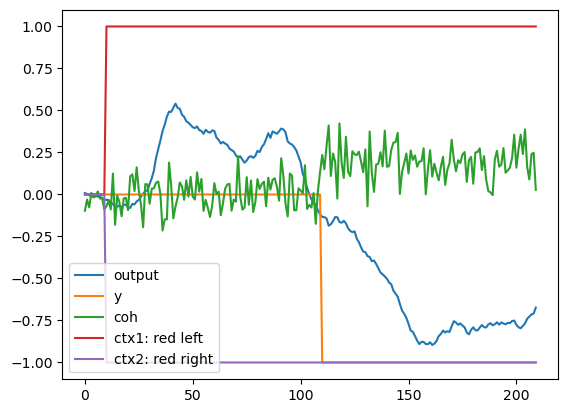

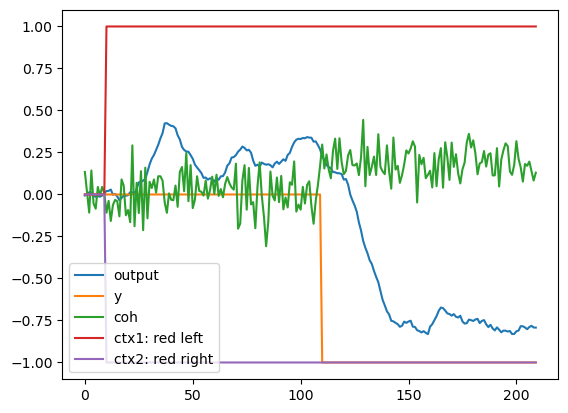

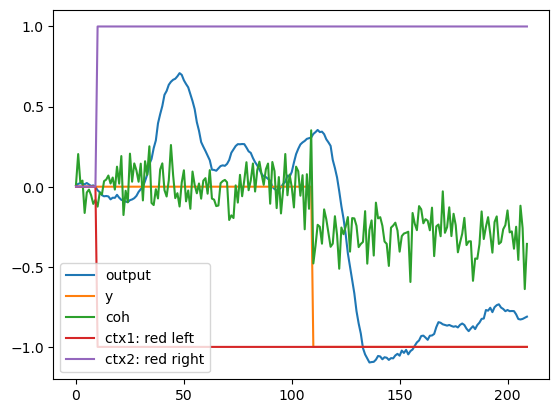

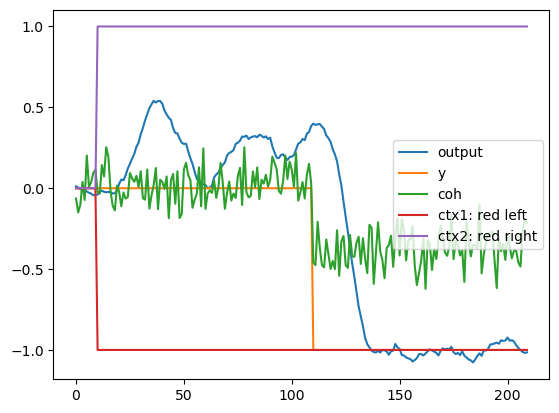

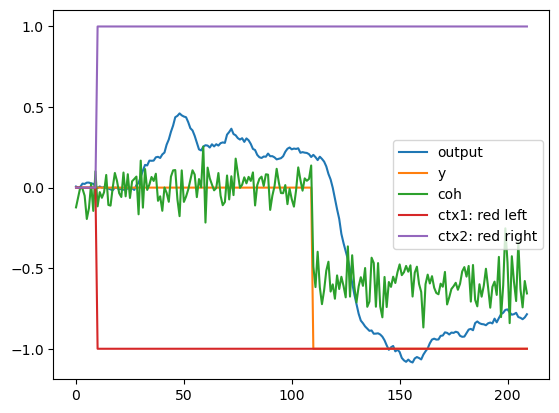

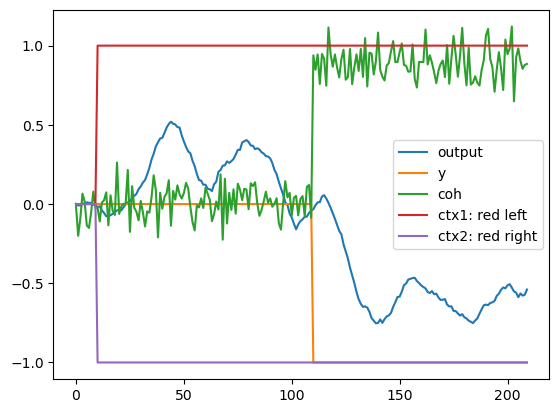

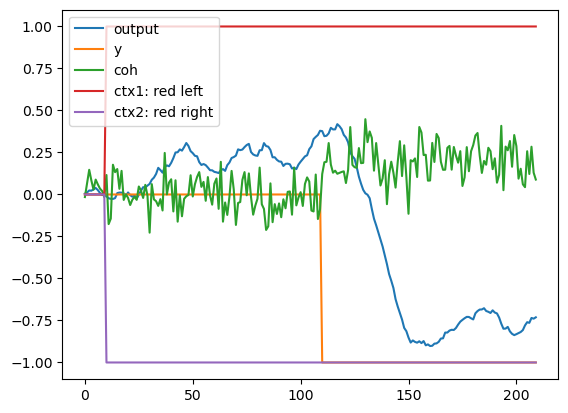

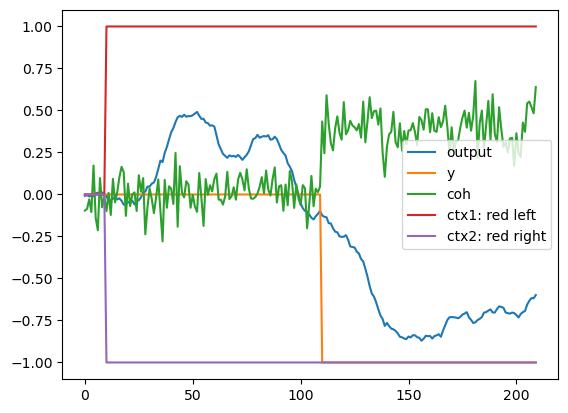

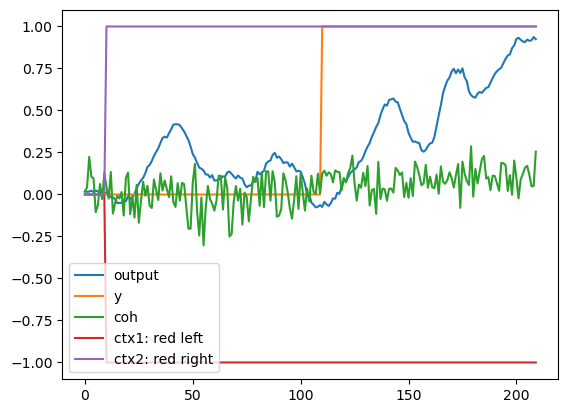

In [10]:
out = out.cpu()
y_val = y_val.cpu()
x_val = x_val.cpu()


for n in range(1, 10):
    plt.figure()
    aa = out.detach().numpy()
    plt.plot(aa[n,:,:], label = 'output')
    plt.plot(y_val[n,:,:], label = 'y')

    plt.plot(x_val[n,:,0], label = 'coh')
    plt.plot(x_val[n,:,1], label = 'ctx1: red left')
    plt.plot(x_val[n,:,2], label = 'ctx2: red right')

    plt.legend()
    plt.show()

# plot psth

In [11]:
traj = traj.cpu()
decisions = decisions.cpu()

traj1 = traj.detach().numpy()

traj1 = np.maximum(traj1,0)
# traj1 = np.maximum(traj1, 0)

decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

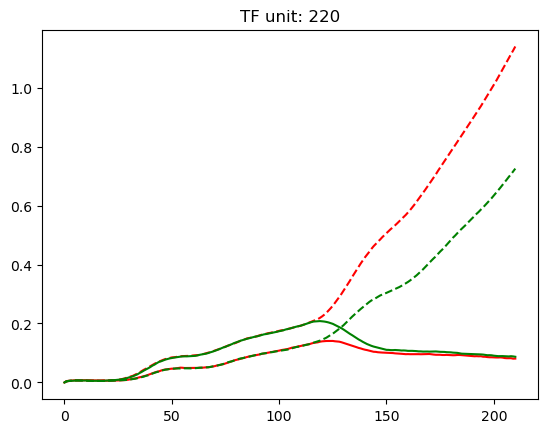

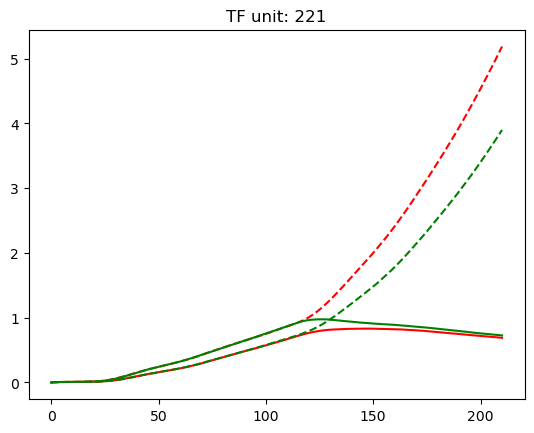

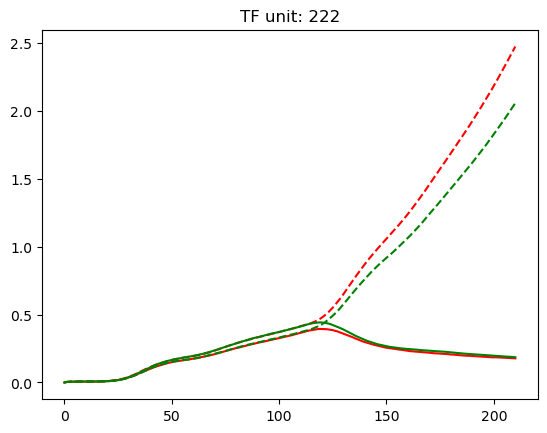

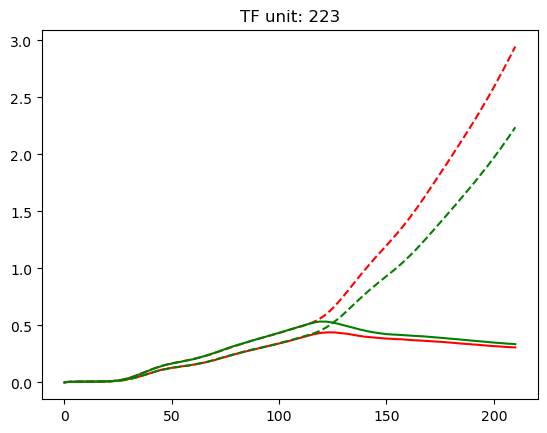

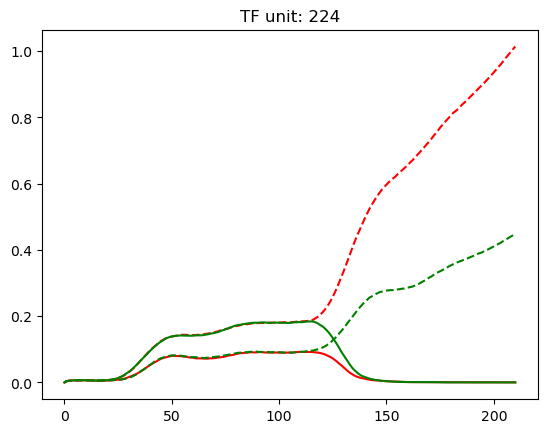

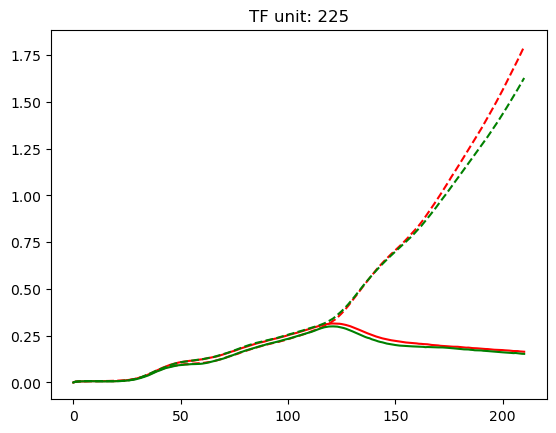

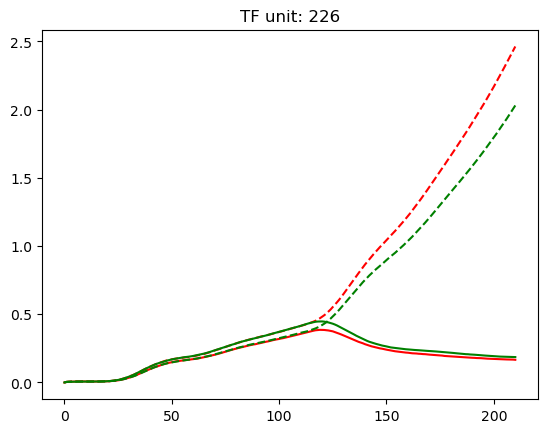

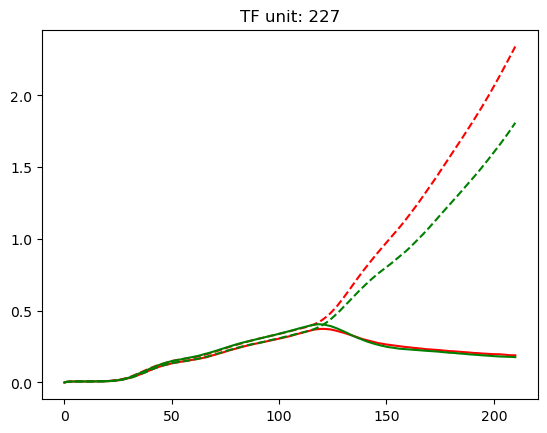

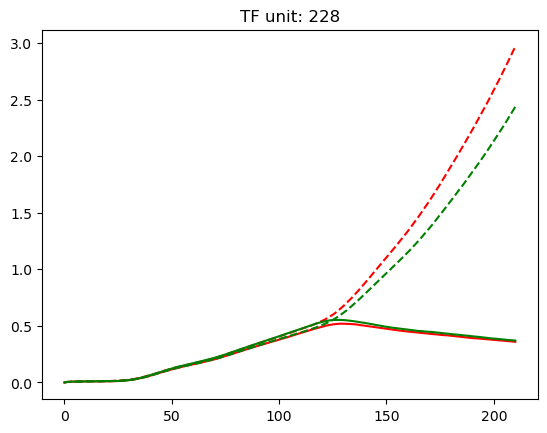

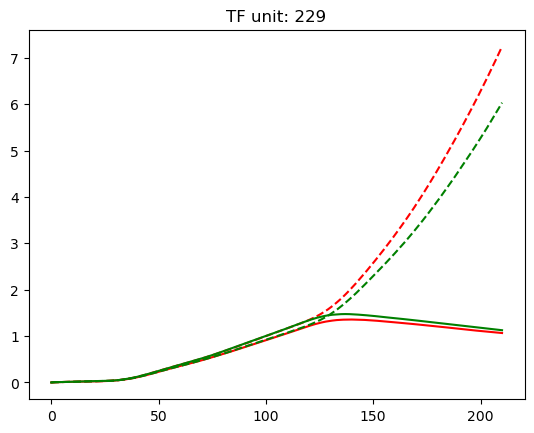

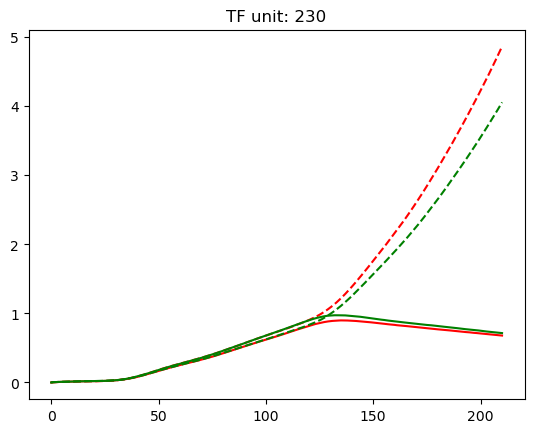

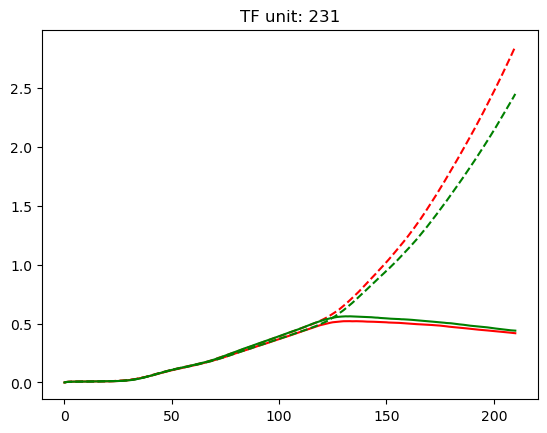

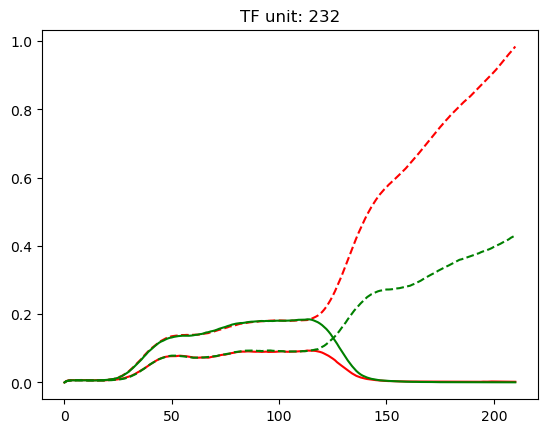

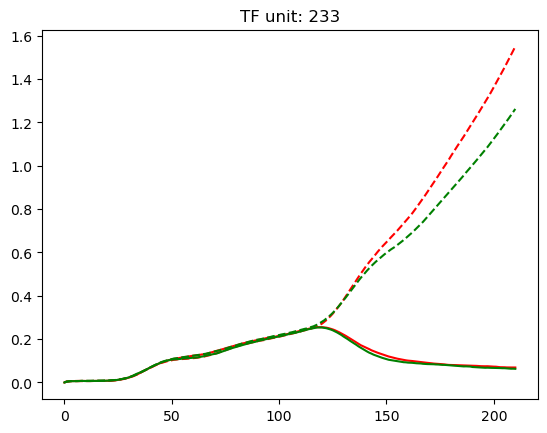

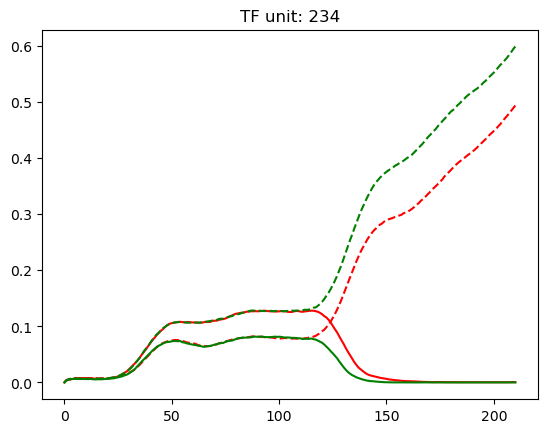

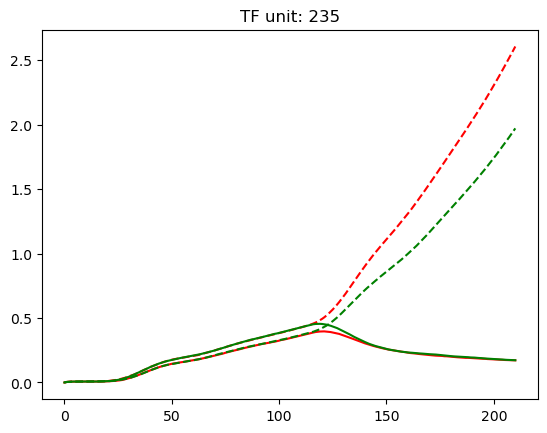

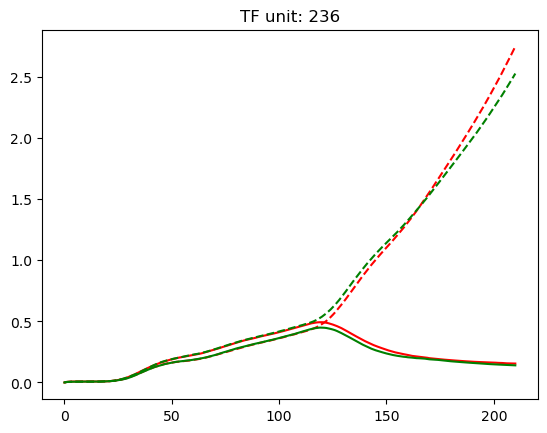

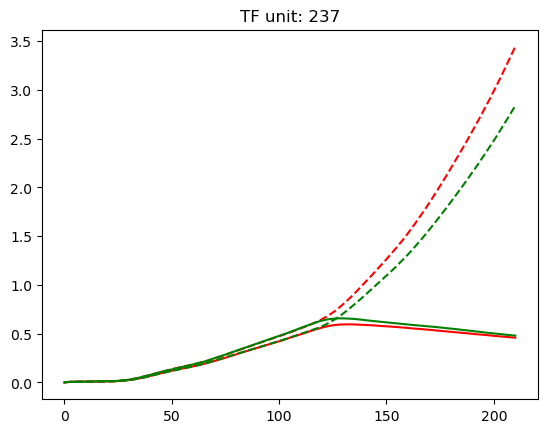

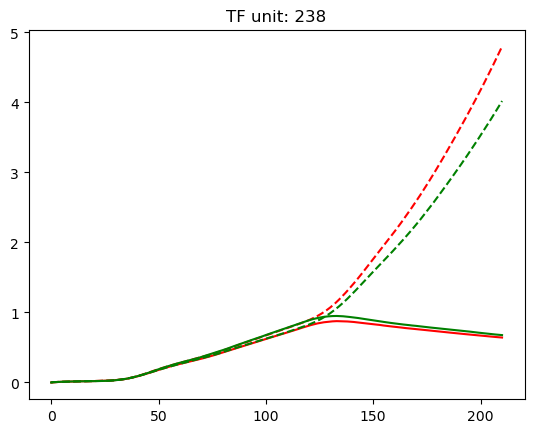

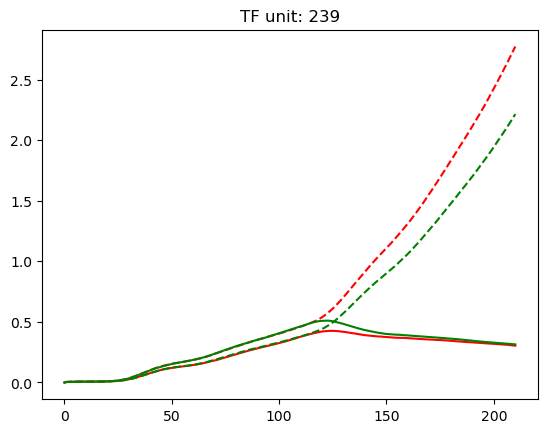

In [15]:
for n in range(220, 240):
    plt.figure()
    plt.plot(np.mean(tfRL,axis = 0)[:,n], 'r-')
    plt.plot(np.mean(tfRR,axis = 0)[:,n], 'r--')
    plt.plot(np.mean(tfGL,axis = 0)[:,n], 'g-')
    plt.plot(np.mean(tfGR,axis = 0)[:,n], 'g--')
    plt.title("TF unit: " + str(n))
    

# plot the connectivity matrix


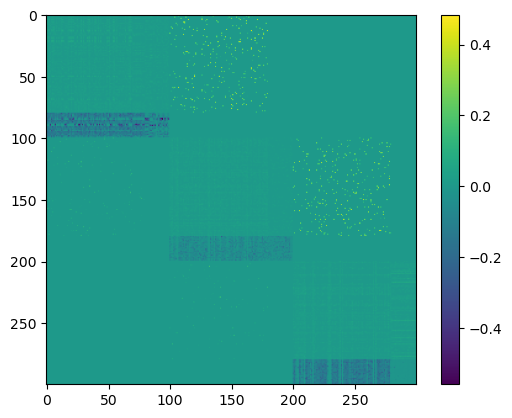

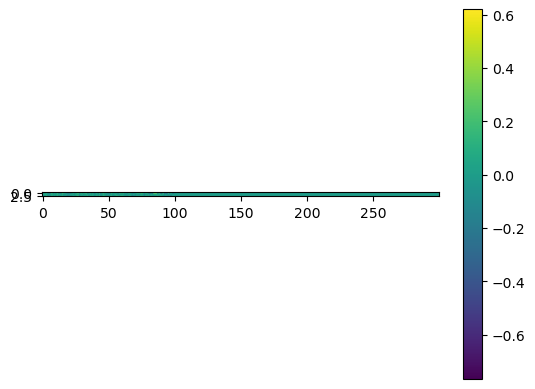

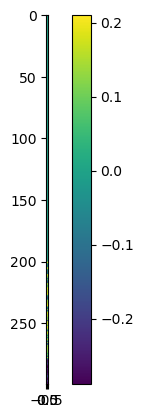

In [16]:
wrec = net.w_rec_eff.cpu()
wi = net.w_in_eff.cpu()
wo = net.w_out_eff.cpu()

a = wrec.detach().numpy()
plt.imshow(a)
plt.colorbar()
plt.set_cmap('viridis')
plt.show()

b = wi.detach().numpy()
plt.imshow(b)
plt.colorbar()
plt.set_cmap('viridis')
plt.show()

c = wo.detach().numpy()
plt.imshow(c)
plt.colorbar()
plt.set_cmap('viridis')
plt.show()


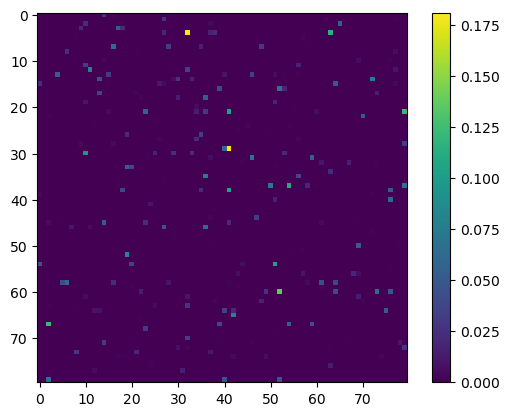

In [17]:
plt.imshow(a[200:280,100:180])
plt.colorbar()

Relative reconstruction error: 8.63e+00


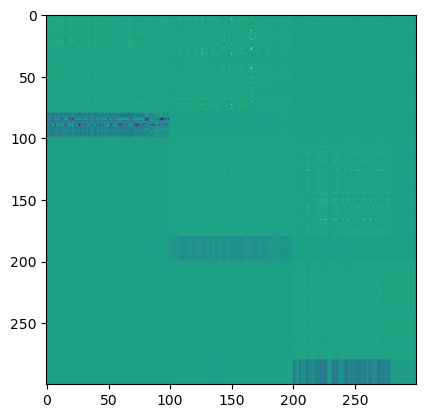

In [18]:
# Perform full SVD
U, S, Vh = torch.linalg.svd(wrec)

# Convert singular values vector to diagonal matrix
S_matrix = torch.diag(S)

# Reconstruct the original matrix
A_reconstructed = U @ S_matrix @ Vh


k = 10  # number of components to keep

U_k = U[:, :k]
S_k = torch.diag(S[:k])
Vh_k = Vh[:k, :]

A_approx = U_k @ S_k @ Vh_k

# Check reconstruction error (optional)
reconstruction_error = torch.norm(mask_rec - A_approx) / torch.norm(wrec)
print(f"Relative reconstruction error: {reconstruction_error:.2e}")

plt.imshow(A_approx)


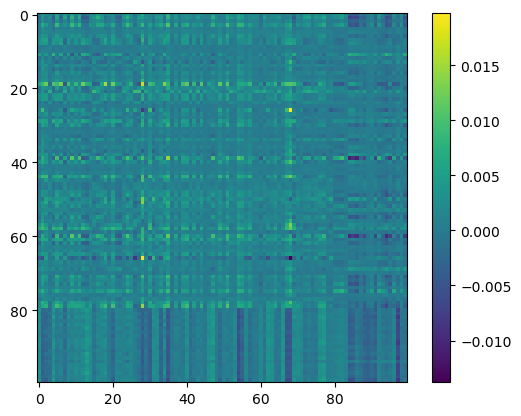

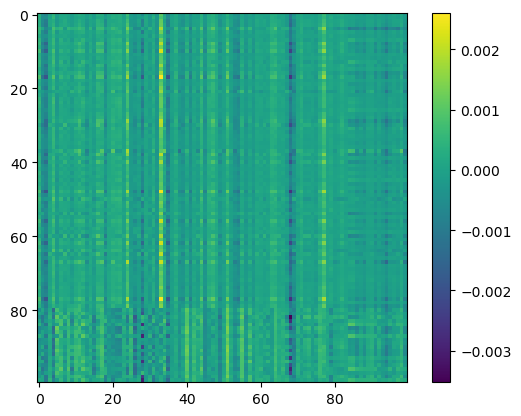

In [22]:
plt.imshow(A_approx[100:200,:100])
plt.colorbar()
plt.show()

plt.imshow(A_approx[200:,:100])
plt.colorbar()
plt.show()